In [1]:
%matplotlib inline

In [2]:
from sparapy.radiosity_fast import DRadiosityFast
from sparapy.radiosity import Radiosity
import sparapy.geometry as geo
import sparapy as sp
import cProfile
from datetime import datetime
import numpy as np


sample_walls = sp.testing.shoebox_room_stub(1, 1, 1)

In [3]:
def init_energy(rad, source_pos):
    source = geo.SoundSource(source_pos, [1, 0, 0], [0, 0, 1])
    E_matrix = []
    for patches in rad.patch_list:
        patches.init_energy_exchange(
            rad.max_order_k, rad.ir_length_s, source,
            sampling_rate=rad.sampling_rate)
        E_matrix.append(patches.E_matrix)
    return E_matrix

def calc_form_factor(rad):
    if len(rad.patch_list) > 1:
        for patches in rad.patch_list:
            patches.calculate_form_factor(rad.patch_list)


In [4]:
n_max = 5
repeat = 2
steps = 3 # create patches, init energy, form factor
steps_names = ['create patches', 'init energy', 'form factor']
fast_second = np.zeros((steps, n_max, repeat))
slow = np.zeros((steps, n_max, repeat))
number_of_patches = np.zeros((n_max))

# run one time, to get complied.
radiosity = DRadiosityFast.from_polygon(sample_walls, 1)
(energy, distance) = radiosity.init_energy([0.5, 0.5, 0.5])
radiosity.check_visibility()
radiosity.calculate_form_factors()

for i in range(n_max):
    max_size = 1/(2**i)
    start_loop = datetime.now()
    print(f'{datetime.now()} run({i}/{n_max}): {max_size}')
    # run fast two times
    for j in range(repeat):
        # create patches
        start = datetime.now()
        radiosity = DRadiosityFast.from_polygon(sample_walls, max_size)
        delta = (datetime.now() - start)
        fast_second[0, i, j] = (delta.seconds*1e6 + delta.microseconds)/repeat

        # init_energy
        start = datetime.now()
        (energy, distance) = radiosity.init_energy([0.5, 0.5, 0.5])
        delta = (datetime.now() - start)
        fast_second[1, i, j] = (delta.seconds*1e6 + delta.microseconds)/repeat

        # form factor
        start = datetime.now()
        radiosity.check_visibility()
        radiosity.calculate_form_factors()
        delta = (datetime.now() - start)
        fast_second[2, i, j] = (delta.seconds*1e6 + delta.microseconds)/repeat

    number_of_patches[i] = radiosity.n_patches
    # Run old
    for j in range(repeat):
        # create patches
        start = datetime.now()
        radiosity_old = Radiosity(sample_walls, max_size, 0, 1)
        delta = (datetime.now() - start)
        slow[0, i, j] = (delta.seconds*1e6 + delta.microseconds)/repeat

        # init_energy
        start = datetime.now()
        E_matrix = init_energy(radiosity_old, [0.5, 0.5, 0.5])
        delta = (datetime.now() - start)
        slow[1, i, j] = (delta.seconds*1e6 + delta.microseconds)/repeat

        # form factor
        start = datetime.now()
        calc_form_factor(radiosity_old)
        delta = (datetime.now() - start)
        slow[2, i, j] = (delta.seconds*1e6 + delta.microseconds)/repeat
    delta = (datetime.now() - start_loop)
    delta_seconds = (delta.seconds*1e6 + delta.microseconds)*1e-6
    print(f'{datetime.now()}   took {delta_seconds} seconds')


2024-05-31 16:37:20.094954 run(0/5): 1.0


/Users/anne/git/_pyfar/sparapy/sparapy/radiosity.py:60: RuntimeWarning: invalid value encountered in divide
  real_size = size/patch_nums


2024-05-31 16:37:20.698160   took 0.603209 seconds
2024-05-31 16:37:20.698205 run(1/5): 0.5
2024-05-31 16:37:20.721478   took 0.023273 seconds
2024-05-31 16:37:20.721491 run(2/5): 0.25
2024-05-31 16:37:21.057434   took 0.335943 seconds
2024-05-31 16:37:21.057455 run(3/5): 0.125
2024-05-31 16:37:25.790945   took 4.73349 seconds
2024-05-31 16:37:25.791022 run(4/5): 0.0625
2024-05-31 16:38:39.858819   took 74.067797 seconds


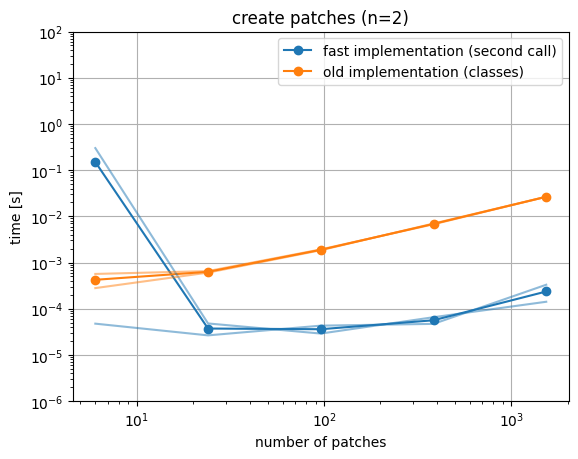

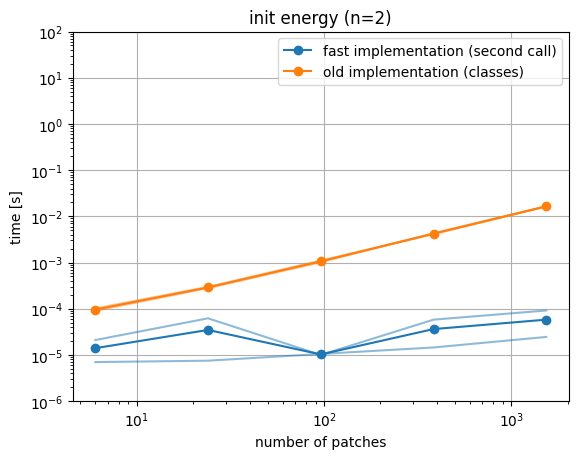

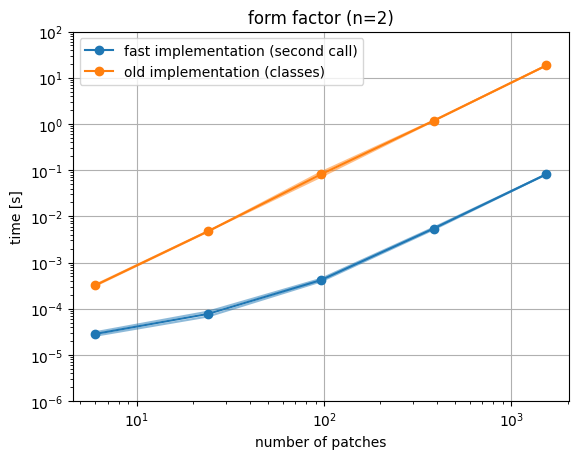

In [5]:
import matplotlib.pyplot as plt

for i in range(steps):
    plt.figure()
    ax = plt.gca()
    # ax.semilogy(number_of_patches, fast_first*1e-6, label='fast implementation (first call)')
    ax.semilogy(
        number_of_patches, np.mean(fast_second[i]*1e-6, axis=-1),
        label='fast implementation (second call)', marker='o')
    ax.semilogy(
        number_of_patches, np.mean(slow[i]*1e-6, axis=-1),
        label='old implementation (classes)', marker='o')
    ax.semilogy(
        number_of_patches, fast_second[i]*1e-6, color='C0', alpha=0.5)
    ax.semilogy(
        number_of_patches, slow[i]*1e-6, color='C1', alpha=0.5)
    ax.grid()
    ax.set_xscale('log')
    ax.set_xlabel('number of patches')
    ax.set_ylabel('time [s]')
    ax.set_title(f'{steps_names[i]} (n={repeat})')
    ax.set_ylim([1e-6, 1e2])
    plt.legend()